# Optimización Bayesiana

**Teorema de Bayes**

$$ P(A|B) = \frac{P(B|A) P(A)}{P(B)} $$

$ P(A|B) $: Probabilidad condicional de A dado B. También conocida como la probabilidad posterior de A dado que B ocurre.

$ P(B|A) $: Probabilidad condicional de B dado A. Se interpreta como la verosimilitud (*likelihood*) de A.

$ P(A) $: Probabilidad de observar A. También conocida como probabilidad a priori.

$ P(B) $: Probabilidad de observar B. Interpretada como evidencia.

Utilizando las definiciones de arriba actualizamos la definición del teorema de bayes:

$$ \text{posterior} = \frac{(\text{verosimilitud})(\text{anterior})}{\text{evidencia}} $$

La intuición es que el teorema de Bayes es una herramienta para actualizar nuestras creencias dado lo que se tenía antes y nueva evidencia. Por ejemplo, tomas una moneda y asumes que es una moneda justa, dado que es lo más probable y que las monedas suelen ser justas en tu experiencia. Lanzas la moneda tres veces y cae sello las tres veces; un poco extraño, así que ajustas tus creencias y empiezas a imaginar que la moneda no es tan justa como debería ser. Lanzas las monedas tres veces y cae águila; ahora crees que la moneda es justa de nuevo.

## ¿Cómo aplicamos esto en nuestra vida diaria?

Imagina que tienes 3 puntos (conocimiento previo) en un espacio.

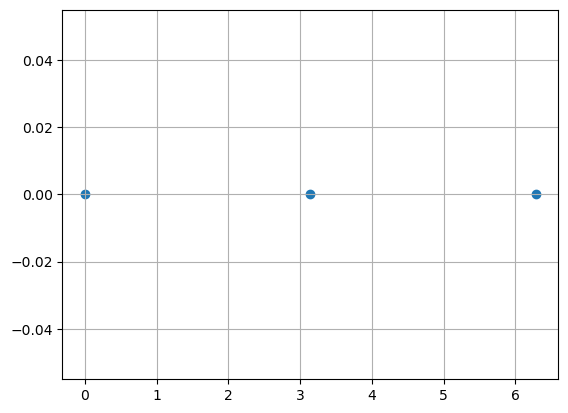

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(); plt.scatter([0, np.pi, 2*np.pi], [0, 0, 0]); plt.grid()

No hay seguridad de cómo se conectan estos puntos, pero sabes que están conectados. Hay infinitas formas en las que estos puntos se pueden conectar.

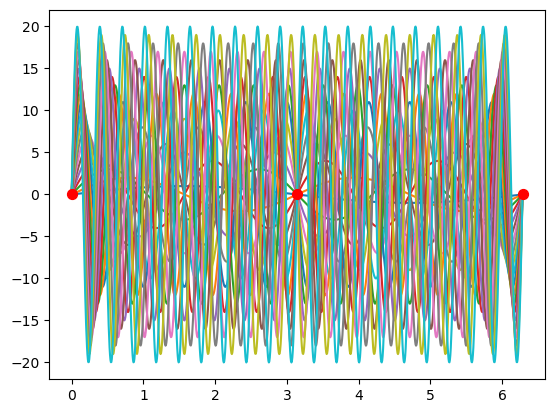

In [2]:
x = np.linspace(0, 2*np.pi, 1000); plt.figure(); 
for i in range(20) :
    y = (i+1)*np.sin((i+1)*x); plt.plot(x, y)
plt.scatter([0, np.pi, 2*np.pi], [0, 0, 0], s=50, c="r", zorder=3)

Hay tanta incertidumbre que decides pedir más información y te dan otro punto.

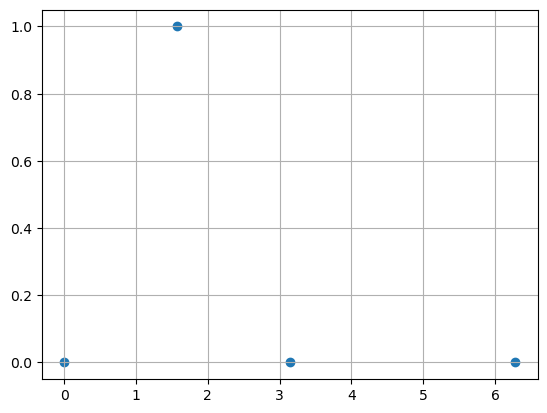

In [3]:
plt.figure(); plt.scatter([0, np.pi, 2*np.pi, np.pi/2], [0, 0, 0, 1]); plt.grid()

Con esta nueva información actualizas tus creencias y reduces la cantidad de formas en las que se conectan estos puntos (siguen siendo infinitas).

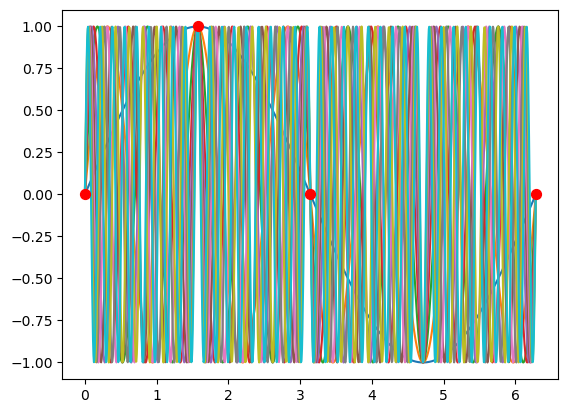

In [4]:
x = np.linspace(0, 2*np.pi, 1000); plt.figure(); 
for i in range(10) :
    y = np.sin((4*i+1)*x); plt.plot(x, y)
plt.scatter([0, np.pi, 2*np.pi, np.pi/2], [0, 0, 0, 1], s=50, c="r", zorder=3)

Te pones a pensar: "Sí. Teóricamente hay infinitas funciones que pueden conectar estos puntos, pero sólo algunas tienen sentido dado mi contexto."

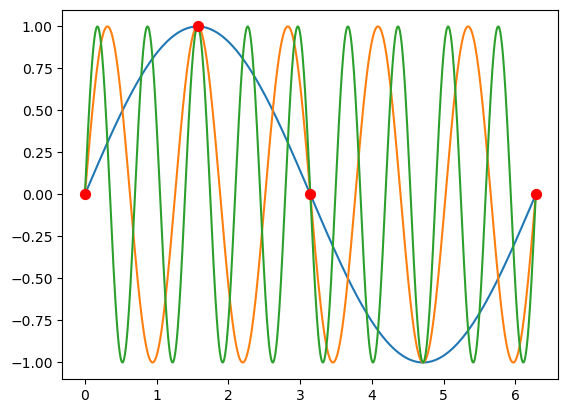

In [5]:
x = np.linspace(0, 2*np.pi, 1000); plt.figure(); 
for i in range(3) :
    y = np.sin((4*i+1)*x); plt.plot(x, y)
plt.scatter([0, np.pi, 2*np.pi, np.pi/2], [0, 0, 0, 1], s=50, c="r", zorder=3)

Ahora sólo quedan algunos pocos candidatos dado el criterio que tienes. Hay incertidumbre sobre cuál de estos candidatos podría ser el que mejor se ajusta, así que decides pedir más información. ¿Qué información serviría más?
- Se podría pedir el valor de $y$ cuando $x=\frac{3\pi}{2}$, pero los candidatos que tenemos todos pasan por el mismo punto. Incluso si nos dieran la información, no ayudaría de mucho.
- Se podría pedir fuera del rango que tenemos, pero quizás la información no existe o dado el contexto del problema es imposible que estos puntos existan.

Nos asignan nuestro último punto.

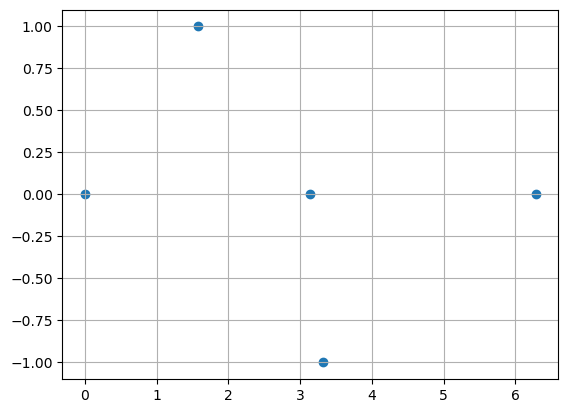

In [6]:
plt.figure(); plt.scatter([0, np.pi, 2*np.pi, np.pi/2, 19*np.pi/18], [0, 0, 0, 1, -1]); plt.grid()

Usamos esta nueva información (evidencia) junto con lo que conocíamos (anterior) y lo que creemos que es posible (verosimilitud) para decidir sobre una nueva función (posterior).

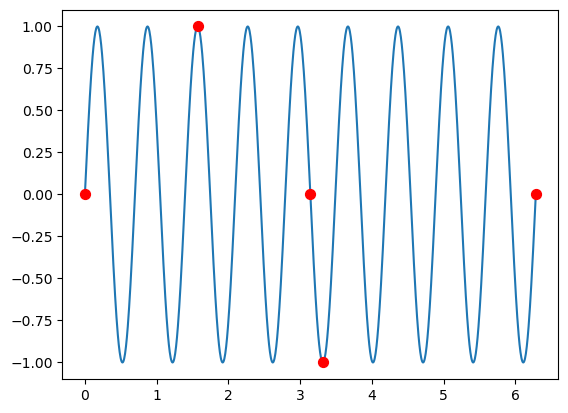

In [7]:
x = np.linspace(0, 2*np.pi, 1000); plt.figure(); y = np.sin(9*x); plt.plot(x, y)
plt.scatter([0, np.pi, 2*np.pi, np.pi/2, 19*np.pi/18], [0, 0, 0, 1, -1], s=50, c="r", zorder=3)

Una forma de realizar este experimento es mediante un proceso gaussiano, que asume que la variable de salida es una variable aleatoria con distribución normal multivariada. Utilicemos la función que encontramos y asumamos que no sabemos cuál es.

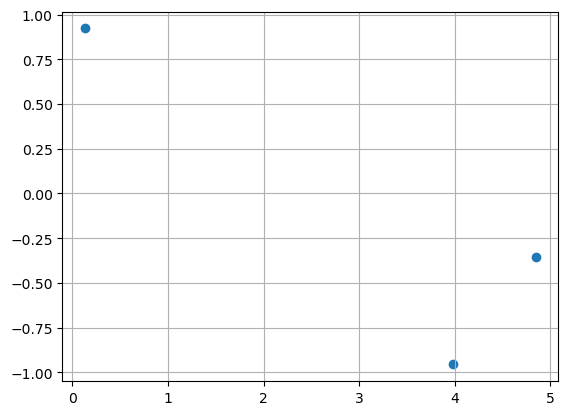

In [8]:
np.random.seed(10)
def f(x) :
    return np.sin(9*x)
X = np.random.uniform(0, 2*np.pi, 3).reshape([-1, 1])
plt.figure(); plt.scatter(X, f(X)); plt.grid()

Realizamos una regresión de proceso gaussiano para encontrar distribuciones que podrían darnos estas muestras

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0*RBF(length_scale = 1)
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 10)

y = f(X)

gp.fit(X, y)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

Creamos un vector de valores posibles de $x$ y predecimos $y$ usando el resultado de la regresión.

In [10]:
test = np.linspace(0, 5, 1000)

test = test.reshape(-1, 1)

y_pred = gp.predict(test)

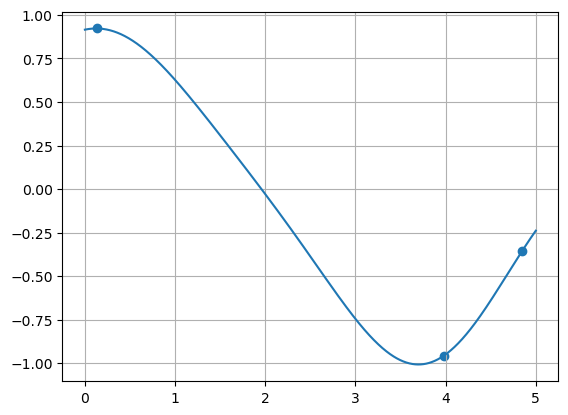

In [11]:
plt.figure(); plt.plot(test, y_pred); plt.grid()
plt.scatter(X, f(X))

Graficamos nuestra primera propuesta, utilizando el error estándar para dibujar nuestros intervalos de confianza.

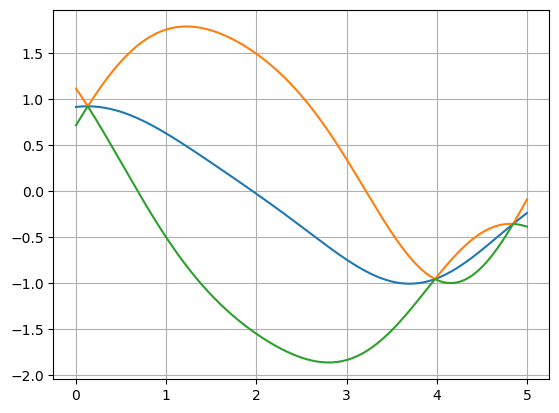

In [12]:
y_pred, y_std = gp.predict(test, return_std = True)

upper = y_pred + 1.96 * y_std
lower = y_pred - 1.96 * y_std

plt.figure(); plt.plot(test, y_pred); plt.grid()
plt.plot(test, upper)
plt.plot(test, lower)

Podemos ver que necesitamos más muestras debido a que hay mucha incertidumbre en algunas partes de nuestro dominio. Hay varios criterios para decidir cómo pedir muestras:
- Maximizar (busco mi predicción del máximo actual y pido esa medida)
- Minimizar (busco mi predicción del mínimo actual y pido esa medida)
- Reducir incertidumbre (busco el punto donde mi intervalo de confianza es más grande y pido esa medida)

In [13]:
lower1 = lower.min()
upper1 = upper.max()

maaxx = upper - lower
maax = maaxx.max()

print(lower1, upper1, maax)

-1.8638933806568736 1.7901482738084256 3.045950013093744


In [14]:
ind = np.argmax(maaxx)
indd = maaxx[ind]
indd

3.045950013093744

Y repetimos el proceso ya con nueva información.

In [15]:
ind = test[ind]
X = np.vstack([X, ind])
X

array([[4.84635053],
       [0.13038834],
       [3.98132928],
       [1.98198198]])

In [16]:
y = f(X)

gp.fit(X, y)

test = np.linspace(0, 5, 1000)

test = test.reshape(-1, 1)

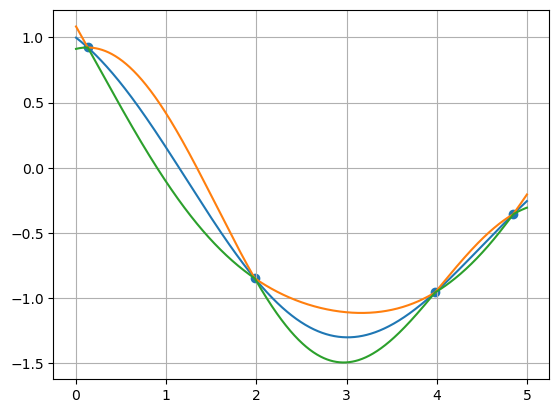

In [17]:
y_pred, y_std = gp.predict(test, return_std = True)

upper = y_pred + 1.96 * y_std
lower = y_pred - 1.96 * y_std

plt.figure(); plt.plot(test, y_pred); plt.grid()
plt.plot(test, upper)
plt.plot(test, lower)
plt.scatter(X, f(X))

Repitamos el proceso 30 veces con una función distinta.

$$ f(x) = \sin{(\frac{x}{3})} + \cos{(2x)},\ \ \ \ x \in [-5\pi, 5\pi] $$

C:\Users\52332\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


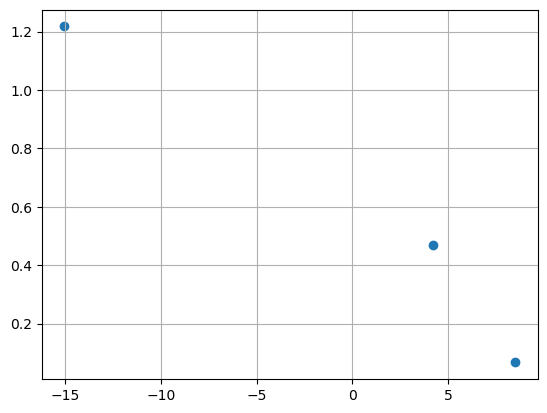

In [18]:
np.random.seed(10)
def f(x) :
    return np.sin(x/3)+np.cos(2*x)
X = np.random.uniform(-5*np.pi, 5*np.pi, 3).reshape([-1, 1])
plt.figure(); plt.scatter(X, f(X)); plt.grid()

kernel = 1.0*RBF(length_scale = 1)
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 10)

y = f(X)

gp.fit(X, y)

test = np.linspace(-5*np.pi, 5*np.pi, 10000)

test = test.reshape(-1, 1)

for i in range(30):
    y_pred, y_std = gp.predict(test, return_std = True)

    upper = y_pred + 1.96 * y_std
    lower = y_pred - 1.96 * y_std
    maaxx = upper - lower
    ind = np.argmax(maaxx)
    ind = test[ind]
    X = np.vstack([X, ind])
    y = f(X)
    gp.fit(X, y)

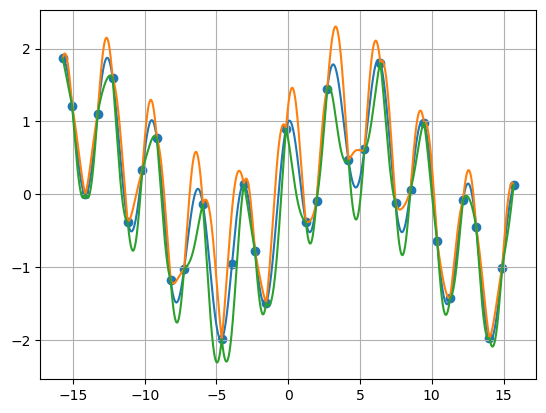

In [19]:
y_pred, y_std = gp.predict(test, return_std = True)

plt.figure(); plt.plot(test, y_pred); plt.grid()
plt.plot(test, upper)
plt.plot(test, lower)
plt.scatter(X, f(X))

### Actividad

1. Modificar el comportamiento de selección para elegir el máximo de las predicciones como el siguiente punto.
2. Modificar el comportamiento de selección para elegir el mínimo de las predicciones como el siguiente punto.

In [20]:
np.random.seed(10)
def f(x) :
    return np.sin(x/3)+np.cos(2*x)
X = np.random.uniform(-5*np.pi, 5*np.pi, 3).reshape([-1, 1])


kernel = 1.0*RBF(length_scale = 1)
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 10)

y = f(X)

gp.fit(X, y)

test = np.linspace(-5*np.pi, 5*np.pi, 10000)

test = test.reshape(-1, 1)

for i in range(30):
    y_pred, y_std = gp.predict(test, return_std = True)

    upper = y_pred + 1.96 * y_std
    lower = y_pred - 1.96 * y_std
    maaxx = upper - lower
    ind = np.argmax(upper)
    ind = test[ind]
    X = np.vstack([X, ind])
    y = f(X)
    gp.fit(X, y)

C:\Users\52332\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\52332\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\52332\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C

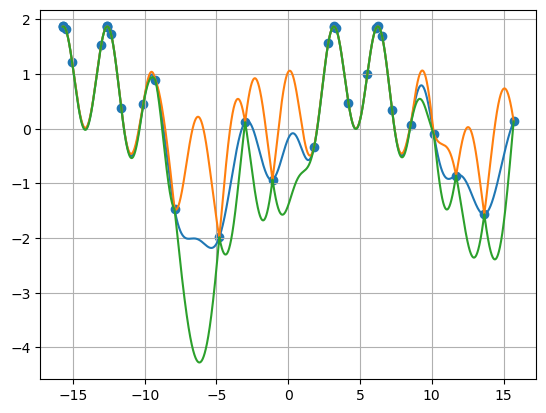

In [21]:
y_pred, y_std = gp.predict(test, return_std = True)

plt.figure(); plt.plot(test, y_pred); plt.grid()
plt.plot(test, upper)
plt.plot(test, lower)
plt.scatter(X, f(X))

In [33]:
np.random.seed(10)
def f(x) :
    return np.sin(x/3)+np.cos(2*x)
X = np.random.uniform(-5*np.pi, 5*np.pi, 3).reshape([-1, 1])


kernel = 1.0*RBF(length_scale = 1)
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 10)

y = f(X)

gp.fit(X, y)

test = np.linspace(-5*np.pi, 5*np.pi, 10000)

test = test.reshape(-1, 1)

for i in range(30):
    y_pred, y_std = gp.predict(test, return_std = True)

    upper = y_pred + 1.96 * y_std
    lower = y_pred - 1.96 * y_std
    maaxx = upper - lower
    ind = np.argmin(lower)
    ind = test[ind].reshape(1, 1)
    X = np.vstack([X, ind])
    y = f(X)
    gp.fit(X, y)

C:\Users\52332\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\52332\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\52332\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C

In [34]:
np.shape(ind)

(1, 1)

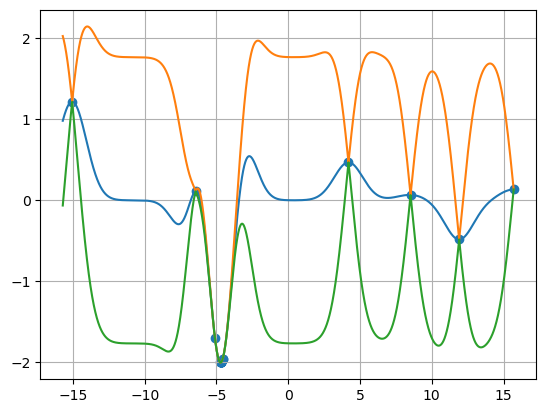

In [35]:
y_pred, y_std = gp.predict(test, return_std = True)

plt.figure(); plt.plot(test, y_pred); plt.grid()
plt.plot(test, upper)
plt.plot(test, lower)
plt.scatter(X, f(X))